In [17]:
# Please execute this cell (shift+<Return>) before starting the workbook
# this should print out "Your notebook is ready to go"
import sys
import tskit
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

if "pyodide" in sys.modules:
    import tqdm
    import micropip
    await micropip.install('jupyterquiz')
    await micropip.install('seaborn')
    await micropip.install('scipy')
    await micropip.install('drawsvg')
    await micropip.install('pyyaml')
import scipy
import wf
import workshop
workbook = workshop.setup_coalescent_handson()
display(workbook.setup)

Your notebook is ready to go!,Clear JupyterLite local storage


# A hands-on introduction to the coalescent


In this exercise the goal is to gain an understanding of how the coalescent works by recreating the algorithm step by step. 

## Some basic properties of the coalescent

Before we start generating coalescent trees, we recapitulate some basic properties and terminology. 



<img src="data/coalescent.svg" width=300  />

The figure above shows a *coalescent tree* or a *genealogy*. The dotted lines highlight time slices $T_i$ that correspond to the *waiting time* for a coalescent event when there are $i$ chromosomes. The waiting time is [*exponentially distributed*](https://en.wikipedia.org/wiki/Exponential_distribution) with intensity $\lambda=\frac{i(i-1)}{2}$ (but see note on time scales below), such that the expected waiting time in state $i$ is 

$$
E(T_i) = \frac{2}{i(i-1)}
$$

As an example, in this time scale, $E(T_2)=1$. Using the expected waiting times we can infer the expected branch lengths. For instance, numbering branches from the leaves going left to right, the fourth branch has length $T_5$, whereas the second branch has length $T_5 + T_4$, and so on.

The *total tree height*, or the time to the most recent common ancestor (MRCA) $T_{MRCA}$, is 

$$
T_{MRCA} = \sum_{i=2}^n T_i
$$

with expected value

$$
E(T_{MRCA}) = \sum_{i=2}^nE(T_i) = 2\sum_{i=2}^n\frac{1}{j(j-1)} = 2\left(1 - \frac{1}{n}\right)
$$

which converges to $E(T_{MRCA})=2$ as $n\rightarrow\infty$. This means that since $E(T_2)=1$, on average a coalescent process spends half of its time waiting for the two last chromosomes to coalesce. A corollary to this is that the return on investment of adding new samples diminishes quickly in terms of adding time to the MRCA.

In [3]:
workbook.question("Q0a")

<IPython.core.display.Javascript object>

Finally, one can show that the expected *total tree length* is

$$
E(T_{total}) = \sum_{i=2}^n iE(T_i) = \sum_{i=2}^n i\frac{2}{i(i-1)} = 2\sum_{i=2}^n\frac{1}{i-1}
$$

<div class="alert alert-block alert-info"><b>A note on time scales</b>
    <br/>
    The basic results regarding some simple properties of coalescent trees may differ according to the choice of time scale. Typically, time is measured in some unit that corresponds to the average time it takes for two chromosomes to find a common ancestor, which is 2N generations. Some treatments use N or 4N as scaling factor, which lead to a factor 2 difference in some of the results. Others count time in generations, omitting scaling altogether. For instance, the coalescent simulator ms scales time in units of 4N, whereas msprime, which we will look at in the next exercise, measures time in generations. For more information on different ways of scaling, see
 <a href="https://tskit.dev/msprime/docs/stable/switch_from_other_simulators.html#scaled-parameters">msprime documentation on scaled parameters</a>.

    
In what follows, one unit of time is equivalent to 2N generations. This has the appealing property that the expressions only depend on the number of chromosomes at a given time step.</div>

## On mutations

Whereas coalescent waiting times are exponentially distributed, mutations ocurr according to a [*Poisson process*](https://en.wikipedia.org/wiki/Poisson_distribution) with intensity $t\theta/2$, where $t$ is the elapsed time, and $\theta$ is the *population mutation parameter*. Since the expected value of a Poisson random variable is equal to its intensity, the expected number of mutations $M_t$ ocurring during time $t$ is 

$$
E(M_t) = \frac{t\theta}{2}
$$

This has important implications. To begin with, the expected number of mutations is proportional to time, which translated to a tree means the number of mutations are proportional to branch length.
Furthermore, the total expected number of mutations $M_T$ for a coalescent tree with total tree branch length $T_{total}$ is

$$
M_T = \frac{T_{total}\theta}{2}
$$

Knowing the parameter $\theta$ and the total tree branch length $T_{total}$, we can then sample a number of mutations from a Poisson distribution with intensity $\theta T_{total}/2$ and sprinkle the mutations on the tree branches.

# Pen and paper coalescent

We will start by tracing out the coalescent with pen and paper, only using the workbook to generate draws from the exponential or Poisson distribution. Make sure to take your time going through each step so you understand what is going on.


## Creating the genealogy

Let's create a genealogy for $n=4$ individuals. The algorithm to create a genealogy is as follows (taken from Hahn 2018):

<b>Algorithm: genealogy creation</b>
<ol>
    <li>Start with $i=n$ chromosomes</li>
    <li>Choose time to next coalescent event from an exponential distribution with parameter $\lambda=i(i-1)/2$</li>
    <li>Choose two chromosomes at random to coalesce</li>
    <li>Merge the two lineages and set $i \rightarrow i - 1$</li>
    <li>If $i>1$, go to step 2; if not, stop.</li>
</ol>

<dl class="exercise"><dt>Exercise 1</dt>
    <dd>Draw four circles next to each other and label them 1-4. Simulate the waiting time with the code below and randomly choose two chromosomes to coalesce. Draw a new circle at a distance proportional to the waiting time above the four circles, label it 5, and connect it with the two coalescing chromosomes. Repeat the procedure by generating a new waiting time and selecting two chromosomes from label 5 and the two uncoalesced start chromosomes, draw a new circle labelled 6 above the four circles and connect to the coalescing chromosomes. Repeat the procedure one last time.
    </dd>
    <dd>
    
In order to facilitate placement of mutations, I recommend you also keep track of the individual branch lengths (equivalent to the time separating a child from its parent). For instance, you could let $t_{ij}$ denote the length of the branch between nodes $i$ and $j$, where $i$ is the child and $j$ the parent index.
    </dd>
</dl>

In [4]:
# Simulate exponential variable.
# NB: scipy.stats uses the *scale* parametrization beta=1/lambda  
lmbda = 6
scipy.stats.expon(scale=1/lmbda).rvs()

0.3253946638673342

In [2]:
workbook.question("Q1")

<IPython.core.display.Javascript object>

When you're done, you should have something similar to the genealogy shown below (note however that your genealogy will have a different topology and different branch lengths due to the stochastic nature of coalescent waiting times and ordering).

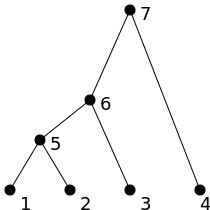

In [6]:
workbook.draw("coalescent_tree")

In this example, the branch length connecting nodes 1 and 5 could be called $t_{15}$ (note that that length equals that of $t_{25}$), and so on. The total tree branch length $T_{total}$ is then the sum of all individual branches $t_{ij}$.

## Adding mutations

Once you have generated a genealogy, it is time to add mutations. We will generate a number of mutations as a Poisson random variable and "throw" the mutations onto branches, where the probability of ending up on a particular branch is proportional to its length with respect to the total tree branch length $T_{total}$. Since we have a simulated tree with known branch lengths $t_{ij}$ (and hence total tree length), we can *condition* on $T_{total}$ and choose a value of $\theta$ to generate an expected number of mutations $S$. 

The total number of mutations is Poisson distributed with mean $T_{total}\theta/2$, where $\theta=4N_e\mu$ is the *population mutation rate*.

In [5]:
workbook.question("Q2")

<IPython.core.display.Javascript object>

Let's choose $\theta$ so the expected number of mutations is $S=5$.

In [2]:
workbook.question("Q3")

<IPython.core.display.Javascript object>

<dl class="exercise"><dt>Exercise 1</dt>
    <dd>Now that you have $T_{total}$ and $\theta$ we can simulate $S$, the number of mutations or the number of *segregating sites*. Also, using the individual branch lengths $t_{ij}$ as weights, for each mutation we can simulate what branch to put it on.

Fill in the values for $T_{total}$, $\theta$, and the vector of branch lengths below and run the code.
    </dd>
    </dl>

In [60]:
# Change the values below to the ones you obtained from your simulation
T_total = 3
theta = 10/3
# Change labels of tij in case your tree topology is different
tij = {"t15": 0.2,
       "t25": 0.2,
       "t56": 0.15,
       "t36": 0.35,
       "t67": 1.05,
       "t47": 1.95}
# Weight the values
p = np.array(list(tij.values()))
p = p / np.sum(p)
S = scipy.stats.poisson(theta*T_total/2).rvs()
# NB: We "flatten" the value return by the multinomial so we can use zip in 
# the next step to map outputs to the dictionary keys
i = scipy.stats.multinomial(n=S, p=p).rvs().flatten()
mutations_per_branch = dict(zip(tij.keys(), i))
mutations_per_branch, S

({'t15': 1, 't25': 0, 't56': 0, 't36': 0, 't67': 0, 't47': 2}, 3)

If all goes well, you should get a dictionary that tells you how many mutations fall on what branch, and as sanity check the number of segregating sites $S$. In your drawing, mark with 'x' the mutations on each branch. Letting `0` represent the ancestral state and `1` the derived state, can you derive the sample sequences?

<div class="alert alert-block alert-info"><b>A note on order of mutations</b>
    <br/>
In the simulation above, there is no explicit ordering of mutations. However, it would be easy to improve the procedure above by, for instance, looping over the mutations to make one multinomial draw at a time and labelling mutations by order of ocurrence.

</div>

# Coded coalescent

In this section, we will code the coalescent using python.

## Simulating the ancestry

Goal: provide code to fill in to generate Newick-formatted output that can be plotted

Call the function sim_ancestry to allow for seamless transition to msprime

Let the users make multiple trees and comment on the height of the trees etc

## Simulating mutations

Goal: provide code to simulate mutations, call function sim_mutations. 

Point out that we are "throwing" mutations on an existing tree, much like msprime throws mutations on a tree sequence.
